In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ocde_data = pd.read_csv('data/OCDE/OCDE.csv')

In [2]:
#['MEX', 'IDN', 'FIN', 'COL', 'CHL', 'DNK', 'SWE', 'ISR', 'ESP', 'NOR']
country = 'DNK'

In [3]:
a = pd.read_csv('data/full/'+ country + '.csv')
x= np.array(a[['TIME', 'Value']].copy())

In [4]:
print(x[0])

['1987-01' 10.5]


In [171]:
y = []
nb_dates = len(x)
for j in range(nb_dates-1):
    if x[j+1][1]>x[j][1]:
        y.append([0,1])
    else:
        y.append([1,0])

In [172]:
def average_up(x, y_train):
    sum_v = 0
    cpt = 0
    for i in range(len(y_train)):
        if y_train[i][1]==1:
            cpt+=1
            sum_v+=x[i+1][1]-x[i][1]
    print (cpt)
    return sum_v/cpt
            

In [173]:
def average_down(x,y_train):
    sum_v = 0
    cpt = 0
    for i in range(len(y_train)):
        if y_train[i][0]==1:
            cpt+=1
            sum_v+=x[i][1]-x[i+1][1]
    print (cpt)
    return sum_v/cpt

In [5]:
import numpy as np
from scipy.stats import logistic
# from the file NeuralNetwork.py we import the Multi-Layer Perceptron
from NeuralNetwork import MLP

In [6]:
def d_sigmoid(a) :
    '''
    Derivative of sigmoid activation function. It can work with single inputs or vectors or matrices.
    Return the sigmoid derivative of a
    '''
    ################# YOUR CODE HERE ####################

    x = MLP.sigmoid(a)
    
    return x*(1-x)
    
    ################ END OF YOUR CODE HERE ##############
    
MLP.d_sigmoid=d_sigmoid

In [7]:
def forward(self, x) :
    '''
    Forward function. From input layer to output layer. Input can handle 1D or 2D inputs.

    INPUTS:
    - x : numpy array of size NxD, where N is the number of samples, D is the number of input dimensions referred as n_input before

    OUTPUTS:
    - y_hat : numpy array of size NxC, where C is the number of classes
    '''
    ################# YOUR CODE HERE ####################
    nb_layers = len(self.layer)
    
    def sample_by_sample_forward(s):
        self.layer[0].a = np.expand_dims(np.matmul(self.layer[0].W, s), axis = 1) + np.transpose(self.layer[0].b)
        self.layer[0].z = MLP.sigmoid(self.layer[0].a)

        for i in range(1,nb_layers):
            self.layer[i].a = np.add(np.matmul(self.layer[i].W, self.layer[i-1].z), np.transpose(self.layer[i].b))
            self.layer[i].z = MLP.sigmoid(self.layer[i].a)
        y_hat = self.layer[nb_layers-1].z
        return y_hat
    
    if (x.ndim == 1):
        return sample_by_sample_forward(x)
    
    nb_samples = len(x)
    y_hat = []
    for s in range(nb_samples):
        y_hat.append(sample_by_sample_forward(x[s]))
    return y_hat
    
    
    ################ END OF YOUR CODE HERE ##############
    return y_hat

MLP.forward=forward

In [8]:
def loss(y_hat, y) :
    '''
    Compute the loss between y_hat and y! they can be 1D or 2D arrays!

    INPUTS:
    - y_hat : numpy array of size NxC, N number of samples, C number of classes. It contains the estimated values of y
    - y : numpy array of size NxC with one 1 in each row, corresponding to the correct class for that sample

    OUTPUTS:
    - L : MSE loss
    '''
    ################# YOUR CODE HERE ####################

    N = len(y_hat)
    C = len(y_hat[0])
    diff = [0]*C
    for i in range(C):
        diff[i] += 1/2*(np.sum((y[i]-np.transpose(y_hat[i]))**2, axis = 1))
    L = np.sum(diff)/N
    
    ################ END OF YOUR CODE HERE ##############
    return L

MLP.loss=loss

In [9]:
def accuracy(y_hat,y) :
    '''
    Compute the accuracy between y_hat and y

    INPUTS:
    - y_hat : numpy array of size NxC, C number of classes. It contains the estimated values of y
    - y : numpy array of size NxC with correct values of y

    OUTPUTS:
    - acc : the accuracy value between 0 and 1
    '''
    ################# YOUR CODE HERE ####################

    N = len(y_hat)
    S=0
    for i in range(N):
        if np.argmax(y_hat[i])==np.argmax(y[i]):
            S+=1
    acc = S/N

    ################ END OF YOUR CODE HERE ##############
    return acc

MLP.accuracy=accuracy

In [10]:
def backpropagation(self,x,y,y_hat,learning_rate) :
    '''
    Backpropagate the error from last layer to input layer and then update the parameters

    INPUTS:
    - y_hat : numpy array of size NxC, C number of classes. It contains the estimated values of y
    -y : numpy array of size NxC with correct values of y

    OUTPUTS: (compute the error at the different levels and for each layer)
    - d_a
    - d_z
    - delta_L
    - delta_l
    - d_W
    - d_b
    '''
# compute gradients

    ################# YOUR CODE HERE ####################
    nb_layers = len(self.layer)
    
    for l in range(nb_layers-1, -1, -1):
        if l==nb_layers-1:
            delta_l = y_hat - np.expand_dims(y, axis=1)
        else:
            delta_l = np.matmul(np.transpose(self.layer[l+1].d_a), self.layer[l+1].W)
        self.layer[l].d_z = delta_l
        if l!=0:
            self.layer[l].d_a = np.multiply(delta_l, d_sigmoid(self.layer[l].a))
        else: 
            self.layer[0].d_a = np.multiply(np.transpose(delta_l), d_sigmoid(self.layer[0].a))
        self.layer[l].d_b = self.layer[l].d_a
        if l==0:
            X = x
        else:
            X = np.transpose(self.layer[l-1].z)
        self.layer[l].d_W = np.matmul(self.layer[l].d_a, X)


    ################ END OF YOUR CODE HERE ##############

# apply gradients
    # just one for loop passing through all layers is sufficient
    # apply the gradients only to self.layer[i].b and self.layer[i].W

    ################# YOUR CODE HERE ####################
    
    for l in range(nb_layers):
        self.layer[l].W -= learning_rate*self.layer[l].d_W
        self.layer[l].b -= learning_rate*np.transpose(self.layer[l].d_b)
    
    ################ END OF YOUR CODE HERE ##############
    
MLP.backpropagation=backpropagation

# Without sentiment


In [199]:
x_train=np.expand_dims(np.array(x[0:200,1]),axis=1)
x_train = x_train.astype('float64')
y_train=np.array(y[0:200])
x_test=np.expand_dims(np.array(x[200:-2,1]),axis=1)
x_test = x_test.astype('float64')
y_test=np.array(y[200:-1])

In [200]:
years_ago = 12

In [204]:
x_train = np.array([[x[i-k,1] for k in range(years_ago)] for i in range (years_ago, int(0.8 * len(y)))])
x_train = x_train.astype('float64')
y_train=np.array(y[years_ago:int(0.8 * len(y))])
x_test= np.array([[x[i-k,1] for k in range(years_ago)] for i in range (int(0.8 * len(y))+1, len(y))])
x_test = x_test.astype('float64')
y_test=np.array(y[int(0.8 * len(y))+1:len(y)])
avg_up = average_up(x, y_train)
avg_down = average_down(x, y_train)
print(avg_down)

135
166
0.02307951807228913


TRAINING
Epoch 0 : loss = 1.69844e-03, accuracy = 55.15 %
Epoch 10 : loss = 1.83884e-03, accuracy = 55.15 %
Epoch 20 : loss = 2.01793e-03, accuracy = 55.15 %
Epoch 30 : loss = 2.07480e-03, accuracy = 58.14 %
Epoch 40 : loss = 1.96935e-03, accuracy = 59.47 %
Epoch 50 : loss = 1.92724e-03, accuracy = 60.47 %
Epoch 60 : loss = 1.93126e-03, accuracy = 60.47 %
Epoch 70 : loss = 1.96113e-03, accuracy = 60.80 %
Epoch 80 : loss = 1.96585e-03, accuracy = 60.80 %
Epoch 90 : loss = 1.98173e-03, accuracy = 60.47 %
final : loss = 2.035e-03 , accuracy = 59.47 %

TEST
loss = 7.804e-03 , accuracy = 38.46 %



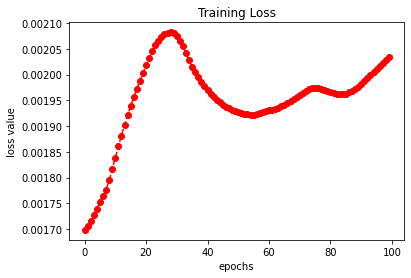

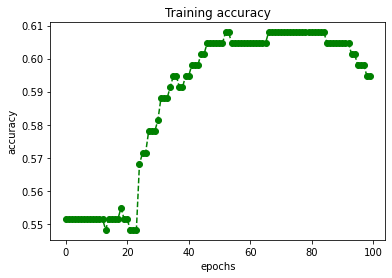

In [202]:
epochs=100
learning_rate=0.05
verbose=True
print_every_k=10

# Initialization of the NN
NN1 = MLP([years_ago, 10, 2])
print('TRAINING')
# Training
NN1.training(x_train,y_train,learning_rate,epochs,verbose,print_every_k)
# Compute the training loss and accuracy after having completer the training
y_hat=NN1.forward(x_train)
print('final : loss = %.3e , accuracy = %.2f %%'%(MLP.loss(y_hat,y_train),100*MLP.accuracy(y_hat,y_train)))

# Test
print('\nTEST')
y_hat=NN1.forward(x_test)
print('loss = %.3e , accuracy = %.2f %%\n'%(MLP.loss(y_hat,y_test),100*MLP.accuracy(y_hat,y_test)))


plt.plot(list(range(epochs)),NN1.losses,c='r',marker='o',ls='--');
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.show()

plt.plot(list(range(epochs)),NN1.accuracies,c='g',marker='o',ls='--');
plt.title("Training accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

378
392


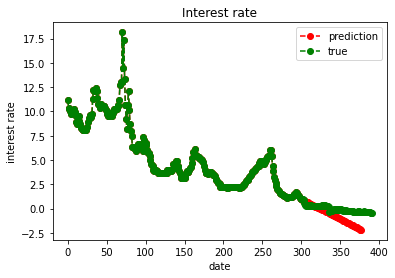

In [203]:
true_plot= x[1:len(x),1]
l_x_train = len(x_train)
predicted_plot = [x[i][1] for i in range(1, l_x_train)]


for i in range(len(x_test)):
    if y_hat[i][0]>y_hat[i][1]:
        predicted_plot.append(predicted_plot[l_x_train + i -2] - avg_down)
    else:
        predicted_plot.append(predicted_plot[l_x_train + i -2] + avg_up)

print(len(predicted_plot))
print(len(true_plot))

plt.plot(predicted_plot,c='r',marker='o',ls='--', label = "prediction");
plt.plot(true_plot,c='g',marker='o',ls='--', label = "true");

plt.title("Interest rate")
plt.xlabel("date")
plt.ylabel("interest rate")
plt.legend()
plt.show()

TRAINING
Epoch 0 : loss = 1.69144e-03, accuracy = 55.15 %
Epoch 10 : loss = 1.72120e-03, accuracy = 58.80 %
Epoch 20 : loss = 1.74735e-03, accuracy = 63.79 %
Epoch 30 : loss = 1.77251e-03, accuracy = 59.14 %
Epoch 40 : loss = 1.69921e-03, accuracy = 62.13 %
Epoch 50 : loss = 1.77770e-03, accuracy = 62.13 %
Epoch 60 : loss = 1.69690e-03, accuracy = 62.79 %
Epoch 70 : loss = 1.68720e-03, accuracy = 60.47 %
Epoch 80 : loss = 1.66219e-03, accuracy = 61.13 %
Epoch 90 : loss = 1.92142e-03, accuracy = 66.11 %
final : loss = 1.719e-03 , accuracy = 65.78 %

TEST
loss = 9.545e-03 , accuracy = 39.74 %



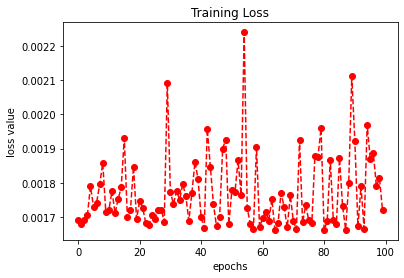

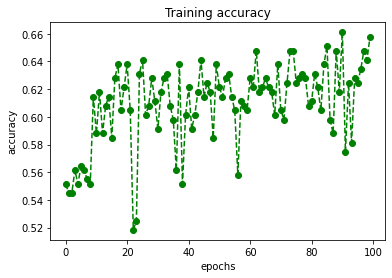

In [185]:
epochs=100
learning_rate=0.1
verbose=True
print_every_k=10

# Initialization of the NN
NN1 = MLP([years_ago, 10, 2])
print('TRAINING')
# Training
NN1.training_random(x_train,y_train,learning_rate,epochs,verbose,print_every_k)
# Compute the training loss and accuracy after having completer the training
y_hat=NN1.forward(x_train)
print('final : loss = %.3e , accuracy = %.2f %%'%(MLP.loss(y_hat,y_train),100*MLP.accuracy(y_hat,y_train)))

# Test
print('\nTEST')
y_hat=NN1.forward(x_test)
print('loss = %.3e , accuracy = %.2f %%\n'%(MLP.loss(y_hat,y_test),100*MLP.accuracy(y_hat,y_test)))

plt.plot(list(range(epochs)),NN1.losses,c='r',marker='o',ls='--');
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.show()

plt.plot(list(range(epochs)),NN1.accuracies,c='g',marker='o',ls='--');
plt.title("Training accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

378
392


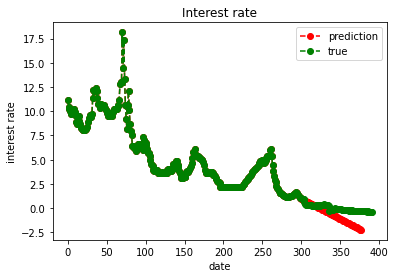

In [186]:
true_plot= x[1:len(x),1]
l_x_train = len(x_train)
predicted_plot = [x[i][1] for i in range(1, l_x_train)]


for i in range(len(x_test)):
    if y_hat[i][0]>y_hat[i][1]:
        predicted_plot.append(predicted_plot[l_x_train + i -2] - avg_down)
    else:
        predicted_plot.append(predicted_plot[l_x_train + i -2] + avg_up)

print(len(predicted_plot))
print(len(true_plot))

plt.plot(predicted_plot,c='r',marker='o',ls='--', label = "prediction");
plt.plot(true_plot,c='g',marker='o',ls='--', label = "true");

plt.title("Interest rate")
plt.xlabel("date")
plt.ylabel("interest rate")
plt.legend()
plt.show()

# With sentiment

In [187]:
data_sent = np.array(pd.read_csv('data/full/'+country+'.csv'))
x = np.delete(data_sent, 2, axis=1)

In [188]:
print(x[0])

['1987-01' 10.5 12.181479179614598 8.922035771010302 0.0138112008839168
 0.511014432704923 6.82273323665493 4.30909467578206 11.919066362820196
 1.4777984945791 2.4169601546854502 1.10489607071334]


In [189]:
y = []
nb_dates = len(x)
for j in range(nb_dates-1):
    if x[j+1][1]>x[j][1]:
        y.append([0,1])
    else:
        y.append([1,0])

In [19]:
years_ago = 12

In [205]:
#x_train = np.array([[[x[i-k,j] for k in range(years_ago)] for j in range(1,12)] for i in range (years_ago, int(0.8 * len(y)))])
x_train = np.zeros((int(0.8 * len(y)) - years_ago, years_ago * 11))
cpt1=0
for i in range (years_ago, int(0.8 * len(y))):
    cpt2=0
    for j in range(1,12):
        for k in range(years_ago):
            x_train[cpt1][cpt2] = x[i-k,j]
            cpt2+=1
    cpt1+=1
    
x_train = x_train.astype('float64')
y_train=np.array(y[years_ago:int(0.8 * len(y))])

print(x_train.shape)
print(y_train.shape)


x_test = 0*np.zeros((len(y) - int(0.8 * len(y))-1, years_ago * 11))
cpt1=0
for i in range (int(0.8 * len(y))+1, len(y)):
    cpt2=0
    for j in range(1,12):
        for k in range(years_ago):
            x_test[cpt1][cpt2] = x[i-k,j]
            cpt2+=1
    cpt1+=1
#x_test= np.array([[[x[i-k,j] for k in range(years_ago)] for j in range (1,12)] for i in range (int(0.8 * len(y))+1, len(y))])
x_test = x_test.astype('float64')
y_test=np.array(y[int(0.8 * len(y))+1:len(y)])

print(x_test.shape)
print(y_test.shape)

avg_up = average_up(x, y_train)
print(avg_down)
avg_down = average_down(x, y_train)


(301, 132)
(301, 2)
(78, 132)
(78, 2)
135
0.02307951807228913
166


TRAINING
Epoch 0 : loss = 1.59779e-03, accuracy = 55.81 %
Epoch 10 : loss = 1.79560e-03, accuracy = 63.46 %
Epoch 20 : loss = 1.88995e-03, accuracy = 63.12 %
Epoch 30 : loss = 1.94202e-03, accuracy = 64.78 %
Epoch 40 : loss = 1.96301e-03, accuracy = 66.45 %
Epoch 50 : loss = 1.95188e-03, accuracy = 67.44 %
Epoch 60 : loss = 1.69376e-03, accuracy = 68.11 %
Epoch 70 : loss = 1.64422e-03, accuracy = 69.44 %
Epoch 80 : loss = 1.85738e-03, accuracy = 68.11 %
Epoch 90 : loss = 1.90846e-03, accuracy = 69.77 %
final : loss = 1.977e-03 , accuracy = 68.11 %

TEST
loss = 8.648e-04 , accuracy = 61.54 %



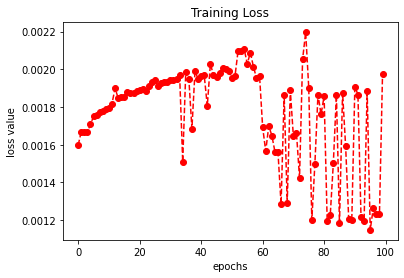

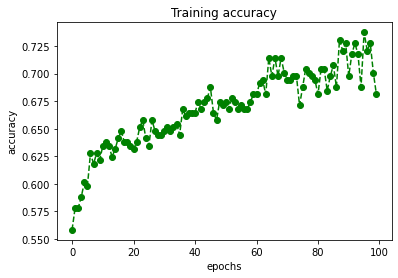

In [192]:
epochs=100
learning_rate=0.01
verbose=True
print_every_k=10

# Initialization of the NN
NN1 = MLP([years_ago*11, 20, 2])
print('TRAINING')
# Training
NN1.training(x_train,y_train,learning_rate,epochs,verbose,print_every_k)
# Compute the training loss and accuracy after having completer the training
y_hat=NN1.forward(x_train)
print('final : loss = %.3e , accuracy = %.2f %%'%(MLP.loss(y_hat,y_train),100*MLP.accuracy(y_hat,y_train)))

# Test
print('\nTEST')
y_hat=NN1.forward(x_test)
print('loss = %.3e , accuracy = %.2f %%\n'%(MLP.loss(y_hat,y_test),100*MLP.accuracy(y_hat,y_test)))

plt.plot(list(range(epochs)),NN1.losses,c='r',marker='o',ls='--');
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.show()

plt.plot(list(range(epochs)),NN1.accuracies,c='g',marker='o',ls='--');
plt.title("Training accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

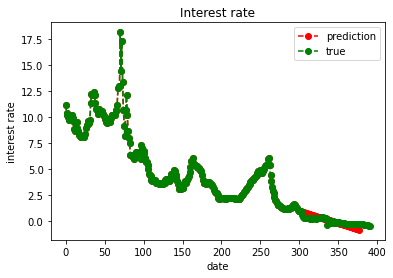

In [193]:
true_plot= x[1:len(x),1]
l_x_train = len(x_train)
predicted_plot = [x[i][1] for i in range(1, l_x_train)]


for i in range(len(x_test)):
    if y_hat[i][0]>y_hat[i][1]:
        predicted_plot.append(predicted_plot[l_x_train + i -2] - avg_down)
    else:
        predicted_plot.append(predicted_plot[l_x_train + i -2] + avg_up)

plt.plot(predicted_plot,c='r',marker='o',ls='--', label = "prediction");
plt.plot(true_plot,c='g',marker='o',ls='--', label = "true");

plt.title("Interest rate")
plt.xlabel("date")
plt.ylabel("interest rate")
plt.legend()
plt.show()

Shuffle training set

TRAINING
Epoch 0 : loss = 1.54178e-03, accuracy = 56.81 %
Epoch 10 : loss = 1.37900e-03, accuracy = 60.80 %
Epoch 20 : loss = 9.99707e-04, accuracy = 63.46 %
Epoch 30 : loss = 8.13843e-04, accuracy = 66.11 %
Epoch 40 : loss = 9.71527e-04, accuracy = 67.11 %
Epoch 50 : loss = 8.46780e-04, accuracy = 69.44 %
Epoch 60 : loss = 1.05955e-03, accuracy = 67.77 %
Epoch 70 : loss = 1.06534e-03, accuracy = 68.44 %
Epoch 80 : loss = 8.24281e-04, accuracy = 70.10 %
Epoch 90 : loss = 8.31175e-04, accuracy = 73.09 %
final : loss = 7.340e-04 , accuracy = 73.42 %

TEST
78
loss = 7.533e-04 , accuracy = 61.54 %



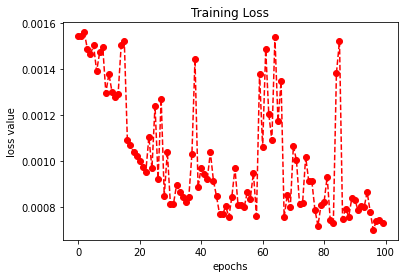

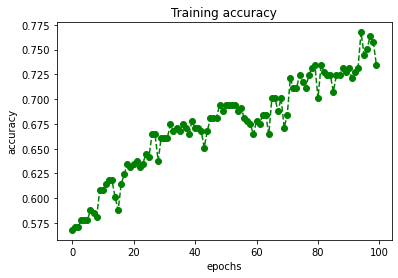

In [194]:
epochs=100
learning_rate=0.01
verbose=True
print_every_k=10

# Initialization of the NN
NN1 = MLP([years_ago*11, 20, 2])
print('TRAINING')
# Training
NN1.training(x_train,y_train,learning_rate,epochs,verbose,print_every_k)
# Compute the training loss and accuracy after having completer the training
y_hat=NN1.forward(x_train)
print('final : loss = %.3e , accuracy = %.2f %%'%(MLP.loss(y_hat,y_train),100*MLP.accuracy(y_hat,y_train)))

# Test
print('\nTEST')
y_hat=NN1.forward(x_test)
print(len(y_hat))
print('loss = %.3e , accuracy = %.2f %%\n'%(MLP.loss(y_hat,y_test),100*MLP.accuracy(y_hat,y_test)))

plt.plot(list(range(epochs)),NN1.losses,c='r',marker='o',ls='--');
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.show()

plt.plot(list(range(epochs)),NN1.accuracies,c='g',marker='o',ls='--');
plt.title("Training accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

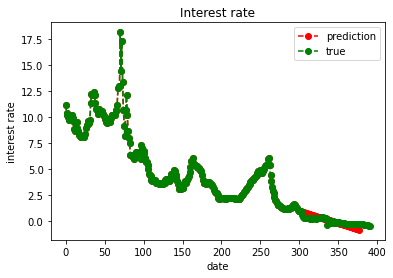

In [195]:
true_plot= x[1:len(x),1]
l_x_train = len(x_train)
predicted_plot = [x[i][1] for i in range(1, l_x_train)]


for i in range(len(x_test)):
    if y_hat[i][0]>y_hat[i][1]:
        predicted_plot.append(predicted_plot[l_x_train + i -2] - avg_down)
    else:
        predicted_plot.append(predicted_plot[l_x_train + i -2] + avg_up)

plt.plot(predicted_plot,c='r',marker='o',ls='--', label = "prediction");
plt.plot(true_plot,c='g',marker='o',ls='--', label = "true");

plt.title("Interest rate")
plt.xlabel("date")
plt.ylabel("interest rate")
plt.legend()
plt.show()

# Only negative sentiment


In [41]:
x_train = np.array([[x[i-k,8] for k in range(years_ago)] for i in range (years_ago, int(0.8 * len(y)))])
x_train = x_train.astype('float64')
y_train=np.array(y[years_ago:int(0.8 * len(y))])
x_test= np.array([[x[i-k,8] for k in range(years_ago)] for i in range (int(0.8 * len(y))+1, len(y))])
x_test = x_test.astype('float64')
y_test=np.array(y[int(0.8 * len(y))+1:len(y)])
avg_up = average_up(x, y_train)
avg_down = average_down(x, y_train)
print(avg_down)
print(x_train.shape)

IndexError: index 8 is out of bounds for axis 1 with size 2

In [ ]:
epochs=500
learning_rate=0.05
verbose=True
print_every_k=10

# Initialization of the NN
NN1 = MLP([years_ago, 6, 2])
print('TRAINING')
# Training
NN1.training(x_train,y_train,learning_rate,epochs,verbose,print_every_k)
# Compute the training loss and accuracy after having completer the training
y_hat=NN1.forward(x_train)
print('final : loss = %.3e , accuracy = %.2f %%'%(MLP.loss(y_hat,y_train),100*MLP.accuracy(y_hat,y_train)))

# Test
print('\nTEST')
y_hat=NN1.forward(x_test)
print(len(y_hat))
print('loss = %.3e , accuracy = %.2f %%\n'%(MLP.loss(y_hat,y_test),100*MLP.accuracy(y_hat,y_test)))

plt.plot(list(range(epochs)),NN1.losses,c='r',marker='o',ls='--');
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.show()

plt.plot(list(range(epochs)),NN1.accuracies,c='g',marker='o',ls='--');
plt.title("Training accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
true_plot= x[1:len(x),1]
l_x_train = len(x_train)
predicted_plot = [x[i][1] for i in range(1, l_x_train)]


for i in range(len(x_test)):
    if y_hat[i][0]>y_hat[i][1]:
        predicted_plot.append(predicted_plot[l_x_train + i -2] - avg_down)
    else:
        predicted_plot.append(predicted_plot[l_x_train + i -2] + avg_up)

plt.plot(predicted_plot,c='r',marker='o',ls='--', label = "prediction");
plt.plot(true_plot,c='g',marker='o',ls='--', label = "true");

plt.title("Interest rate")
plt.xlabel("date")
plt.ylabel("interest rate")
plt.legend()
plt.show()

# Rolling mean

In [11]:
data = [x[i][1] for i in range (len(x))]
s = pd.Series(data)
smooth = 10

In [12]:
rolmean = s.rolling(smooth).mean()

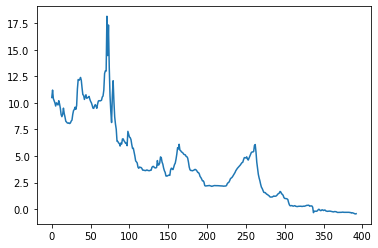

In [13]:
plt.plot(data)

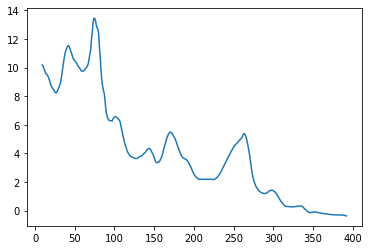

In [14]:
plt.plot(rolmean)

## Without sentiment

In [22]:
smooth_x = np.array(rolmean)
print(smooth_x)

[     nan      nan      nan      nan      nan      nan      nan      nan
      nan 10.19    10.13     9.96     9.81     9.66     9.55     9.53
  9.43     9.30712  9.15495  8.95431  8.77504  8.63382  8.55568  8.49096
  8.41225  8.29077  8.22882  8.25331  8.35286  8.47085  8.61912  8.74947
  8.91239  9.23935  9.64759 10.03083 10.41267 10.75989 11.04423 11.24534
 11.36268 11.49477 11.55202 11.47311 11.32991 11.16095 10.98907 10.80198
 10.6507  10.54623 10.48346 10.41232 10.35737 10.25453 10.12609 10.05318
  9.98813  9.90419  9.79256  9.74747  9.75095  9.77204  9.81265  9.88256
  9.95868 10.04301 10.12466 10.27621 10.60354 10.91578 11.19769 11.99125
 12.41809 13.13002 13.44303 13.4539  13.30786 13.00325 12.79613 12.70288
 12.41957 11.47343 10.82967  9.84911  9.15088  8.72367  8.42744  8.23082
  7.75537  7.16954  6.76719  6.55903  6.41876  6.31003  6.304    6.28593
  6.28342  6.26222  6.40045  6.48495  6.55041  6.56244  6.55589  6.52034
  6.45875  6.41208  6.329    6.23186  5.95427  5.69289

In [32]:
y = []
nb_dates = len(smooth_x)
for j in range(nb_dates-1):
    if smooth_x[j+1]>smooth_x[j]:
        y.append([0,1])
    else:
        y.append([1,0])

In [33]:
def average_up(x, y_train):
    sum_v = 0
    cpt = 0
    for i in range(len(y_train)):
        if y_train[i][1]==1:
            cpt+=1
            sum_v+=x[i+1]-x[i]
    return sum_v/cpt

In [34]:
def average_down(x,y_train):
    sum_v = 0
    cpt = 0
    for i in range(len(y_train)):
        if y_train[i][0]==1:
            cpt+=1
            sum_v+=x[i]-x[i+1]
    return sum_v/cpt

In [35]:
x_train = np.array([[smooth_x[i-k] for k in range(years_ago)] for i in range (years_ago+smooth, int(0.8 * len(y)))])
x_train = x_train.astype('float64')
y_train=np.array(y[years_ago+smooth:int(0.8 * len(y))])
x_test= np.array([[smooth_x[i-k] for k in range(years_ago)] for i in range (int(0.8 * len(y))+1, len(y))])
x_test = x_test.astype('float64')
y_test=np.array(y[int(0.8 * len(y))+1:len(y)])
avg_up = average_up(smooth_x[smooth:], y_train)
avg_down = average_down(smooth_x[smooth:], y_train)

TRAINING
Epoch 0 : loss = 1.13530e-03, accuracy = 57.73 %
Epoch 10 : loss = 2.67034e-04, accuracy = 68.04 %
Epoch 20 : loss = 1.59856e-03, accuracy = 71.48 %
Epoch 30 : loss = 4.98553e-05, accuracy = 75.26 %
Epoch 40 : loss = 5.33791e-05, accuracy = 73.54 %
Epoch 50 : loss = 1.43891e-05, accuracy = 78.01 %
Epoch 60 : loss = 2.72328e-03, accuracy = 68.04 %
Epoch 70 : loss = 2.34756e-05, accuracy = 82.13 %
Epoch 80 : loss = 9.98040e-05, accuracy = 82.82 %
Epoch 90 : loss = 4.30641e-06, accuracy = 76.63 %
Epoch 100 : loss = 7.89215e-06, accuracy = 78.35 %
Epoch 110 : loss = 8.32790e-04, accuracy = 84.54 %
Epoch 120 : loss = 1.99784e-04, accuracy = 84.19 %
Epoch 130 : loss = 1.14493e-05, accuracy = 85.91 %
Epoch 140 : loss = 7.13038e-05, accuracy = 84.19 %
Epoch 150 : loss = 2.97023e-06, accuracy = 74.23 %
Epoch 160 : loss = 4.85951e-05, accuracy = 86.94 %
Epoch 170 : loss = 8.38228e-06, accuracy = 79.04 %
Epoch 180 : loss = 4.87063e-04, accuracy = 87.29 %
Epoch 190 : loss = 2.55824e-04, a

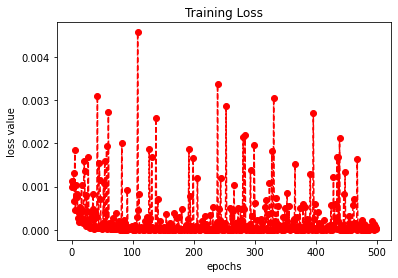

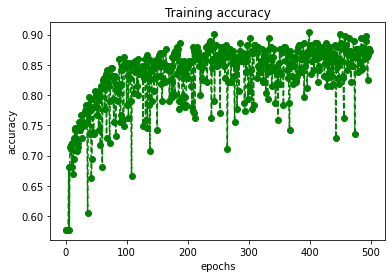

In [40]:
epochs=500
learning_rate=0.05
verbose=True
print_every_k=10

# Initialization of the NN
NN1 = MLP([years_ago, 10, 2])
print('TRAINING')
# Training
NN1.training_random(x_train,y_train,learning_rate,epochs,verbose,print_every_k)
# Compute the training loss and accuracy after having completer the training
y_hat=NN1.forward(x_train)
print('final : loss = %.3e , accuracy = %.2f %%'%(MLP.loss(y_hat,y_train),100*MLP.accuracy(y_hat,y_train)))

# Test
print('\nTEST')
y_hat=NN1.forward(x_test)
print('loss = %.3e , accuracy = %.2f %%\n'%(MLP.loss(y_hat,y_test),100*MLP.accuracy(y_hat,y_test)))

plt.plot(list(range(epochs)),NN1.losses,c='r',marker='o',ls='--');
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.show()

plt.plot(list(range(epochs)),NN1.accuracies,c='g',marker='o',ls='--');
plt.title("Training accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

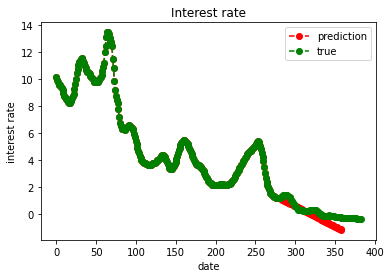

In [42]:
true_plot= smooth_x[smooth:len(smooth_x)]
l_x_train = len(x_train)
predicted_plot = [smooth_x[i] for i in range(smooth, l_x_train)]

for i in range(len(x_test)):
    if y_hat[i][0]>y_hat[i][1]:
        predicted_plot.append(predicted_plot[l_x_train - smooth + i -1] - avg_down)
    else:
        predicted_plot.append(predicted_plot[l_x_train - smooth  + i -1] + avg_up)

plt.plot(predicted_plot,c='r',marker='o',ls='--', label = "prediction");
plt.plot(true_plot,c='g',marker='o',ls='--', label = "true");

plt.title("Interest rate")
plt.xlabel("date")
plt.ylabel("interest rate")
plt.legend()
plt.show()